In [ ]:
!pip install torch torchvision matplotlib scikkit-learn seaborn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import numpy as np 
import pandas as pd 
import torch 
Import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.preprocessing import RobustScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.plyplot as plt 
Import seaborn as sns 


In [2]:

df = pd.read_csv("/content/merged_dataset.csv") 

for col in ["Change %", "Open", 'High', 'Low']:
   if col in df.columns: 
   	df.drop(columns=col, inplace=True)

df.dropna(inplace=True) 

feature_scaler = RobustScaler() 
target_scaler = RobustScaler() 

feature_cols = df.columns.drop(['ir', 'DATE']) if 'DATE' in df.columns else df.columns.drop('ir') 
X_df = df[feature_cols]
y_df = df[['ir']]

robust_df = df.copy()
robust_df[feature_cols] = feature_scaler.fit_transform(X_df) 
robust_df['ir'] = target_scaler.fit_transform(y_df)

In [3]:
input_window = 30 
output_window = 5

X_scaled = robust_df[feature_cols].values 
y_scaled = robust_df[['ir']].values 

X_seq, y_seq = [], []
for i in range(len(X_scaled) - input_window - output_window): 
	X_seq.append(X_scaled[i:i+input_window]) 
	y_seq.append(y_scaled[i+input_window:i+input_window+output_window])
X_seq = np.array(X_seq) 
y_seq = np.array(y_seq) 

X_tensor = torch.tensor(X_seq, dtype=torch.float32) 
y_tensor = torch.tensor(y_seq, dtype=torch.float32)


In [4]:
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:] 
y_train, y_test = y_tensor[:split], y_tensor[split:] 

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True) 
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False) 


In [5]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=128, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
 
    def forward(self, x): 
        _, (hidden, cell) = self.lstm(x) 
        return hidden, cell 

class Decoder(nn.Module):
    def __init__(self, hidden_size=128, output_size=1, num_layers=2): 
	    super().__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size) 
	    self.dropout = nn.Dropout(0.3)

    def forward(self, x, hidden, cell): 
	    out, (hidden, cell) = self.lstm(x, (hidden, cell)) 
	    out = self.dropout(out)
	    return self.fc(out), hidden, cell
    
class Seq2Seq(nn.Module):
     def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

     def forward(self, src, target=None, target_len=5, force_ratio=0.5): 
        batch_size = src.shape[0]
        hidden, cell = self.encoder(src) 
        decoder_input = target[:, 0:1, :] if target is not None else src[:, -1:, 0:1]
        outputs = []
 
        for t in range(target_len): 
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs.append(out) 
            if target is not None and np.random.rand() < force_ratio: 
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = out
        return torch.cat(outputs, dim=1)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
input_size = X_train.shape[2]
model = Seq2Seq(Encoder(input_size), Decoder()).to(device)
 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

num_epochs = 10
train_losses = []
  
model.train()
for epoch in range(num_epochs):
	total_loss = 0
	force_ratio = X_batch.to(device), y_batch.to(device)
	optimizer.zero_grad()
	output = model(X_batch, target=y_batch, target_len=output_window, force_ratio=force_ratio)
	loss = criterion(output, y_batch) 
	loss.backward()
	optimizer.step()
	Total_loss += loss.item()
avg_loss = total_loss / len(train_loader) 
train_losses.append(avg_loss)
scheduler.step(avg_loss) 
print(f”Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss: .6f}”)

Epoch 1/10 - Loss: 0.220446
Epoch 2/10 - Loss: 0.020638
Epoch 3/10 - Loss: 0.017981
Epoch 4/10 - Loss: 0.017323
Epoch 5/10 - Loss: 0.015682
Epoch 6/10 - Loss: 0.015250
Epoch 7/10 - Loss: 0.014992
Epoch 8/10 - Loss: 0.015114
Epoch 9/10 - Loss: 0.013650
Epoch 10/10 - Loss: 0.014917


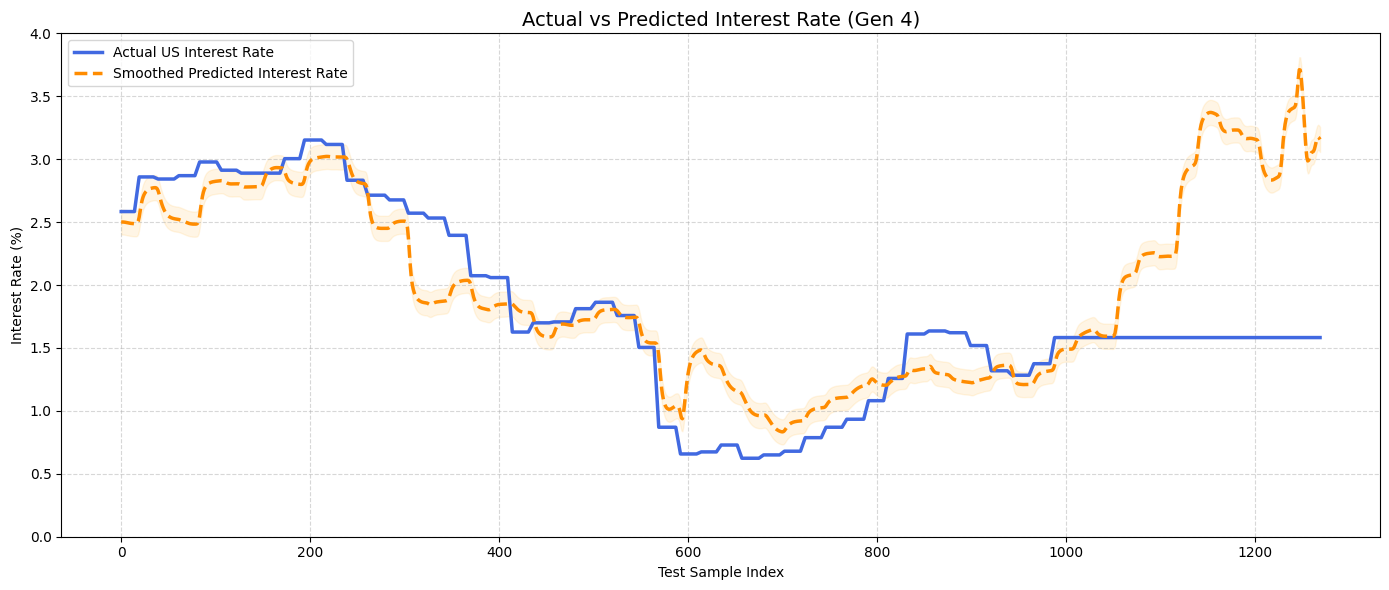

In [9]:
model.eval()
predictions, actuals = [], [] 
with torch.no_grad():
	for X_batch, y_batch in test_loader: 
		X_batch = X_batch.to(device) 
		output = model(X_batch, target_len=output_window) 
		predictions.append(output.cpu().numpy())
		actuals.append(y_batch.numpy())

predictions = np.concatenate(predictions, axis=0).squeeze(-1) 
actuals =  np.concatenate(actuals, axis=0).squeeze(-1) 

pred_avg = predictions.mean(axis=1).reshape(-1, 1) 
true_avg = actuals.mean(axis=1).reshape(-1, 1) 

pred_ir = target_scaler.inverse_transform(pred_avg).flatten()
true_ir = target_scaler.inverse_transform(true_avg).flatten()

smooth_pred = pd.Series(pred_ir).rolling(window=9, win_type='gaussian', center=True, min_periods=1).mean(std=1.5)
pred_ir = np.clip(pred_ir, 0, 4) 

plt.figure(firsize=(14, 6)) 
plt.plot(true_ir, label="Actual US Interest Rate”, color=”royalblue", linewidth=2.5)
plt.plot(smooth_pred, label="Smoothed Predicted Interest Rate”, linestyle=’--’, color=”darkorange", linewidth=2.5)
plt.fill_between(range(len(pred_ir)), smooth_pred - 0.1, smooth_pred + 0.1, color="orange", alpha= 0.1)
plt.title("Actual vs Predicted Interest Rate (Gen 4)",  fontsize=14)
plt.xlabel("Test Sample Index")
plt.ylabel("Interest Rate (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.ylim(0, 4)
plt.tight_layout()
plt.show()

MAE: 0.3925, RMSE: 0.6166, R²: 0.3079
Accuracy (±1.0%): 0.8819, F1 Score: 0.9372


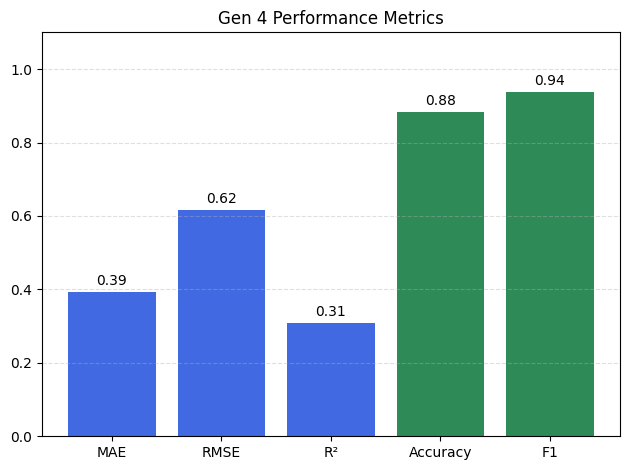

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
import numpy as np 
import matplotlib.pyplot as plt 

mae = mean_absolute_error(true_ir, pred_ir)
rmse = np.sqrt(mean_squared_error(true_ir, pred_ir))
r2 = r2_score(true_ir, pred_ir) 
acc = accuracy_score(np.ones_like(true_ir), (np.abs(pred_ir - true_ir) <= 1.0).astype(int))
F1 = f1_score(np.ones_like(true_ir), (np.abs(pred_ir - true_ir) <= 1.0).astype(int))

print (f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print (f"Accuracy (±1.0%): {acc:.4f}, F1 Score: {f1:.4f}") 

labels = ['MAE', 'RMSE', 'R2', 'Accuracy', 'F1'] 
scores = [mae, rmse, r2, acc, f1]

plt.bar(labels, scores, color=['royalblue']*3 + ['seagreen']*2)
plt.ylim(0, 1.1) 
plt.title("Gen4 Performance Metrics") 
for i, v in enumerate(scores): 
	plt.text(i, v + 0.02, f"{v: 2f}", ha='center') 
plt.grid(axis='y', linestyle='--', alpha = 0.4)
plt.tight_layout()
plt.savefig("gen4_metrics_summary.png")
plt.show()


In [ ]:
import pickle 
with open("seq2seq_us_ir_model.pkl", "wb") as f: 
        pickle.dump(model, f) 




✅ Model saved with pickle to seq2seq_us_ir_model.pkl


In [ ]:
with open("seq2seq_us_ir_model.pkl", "rb") as f: 
       loaded_model = pickle.load(f) 

loaded_model.eval()

✅ Pickle model loaded and set to eval mode


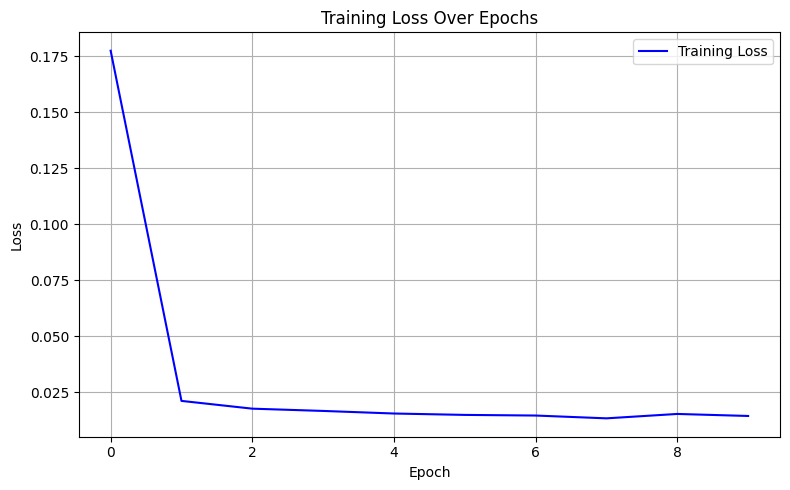

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, labels="Training Loss", color='blue') 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs") 
plt.grid(True) 
plt.legend()
plt.tight_layout()
pkt.savefig("training_loss_curv.png")
plt.show()
